<a href="https://colab.research.google.com/github/raghad595/Gait_Recognition/blob/main/full_gait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title 1. Setup and Download CASIA-B from Kaggle
# We use kagglehub to download the dataset directly to the Colab runtime.

# Install necessary libraries
!pip install torchinfo torchmetrics kagglehub opencv-python

import kagglehub
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from torchinfo import summary
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from PIL import Image

# --- Download Dataset ---
print("Downloading CASIA-B dataset from Kaggle...")
path = kagglehub.dataset_download("trnquanghuyn/casia-b")
print("✅ Dataset downloaded to:", path)

# --- Configure Paths ---
# We set the root to the downloaded path.
# NOTE: We perform a quick check to see if the data is inside a subfolder
# (e.g., /path/CASIA-B/001 vs /path/001) or inside an 'output' folder
if 'CASIA-B' in os.listdir(path):
    DATASET_ROOT = os.path.join(path, 'CASIA-B')
elif 'output' in os.listdir(path):
    DATASET_ROOT = os.path.join(path, 'output')
else:
    DATASET_ROOT = path

OUTPUT_GEI_DIR = '/content/gei_dataset'
OUTPUT_PARTS_DIR = '/content/parts_dataset'

# Create output directories
os.makedirs(OUTPUT_GEI_DIR, exist_ok=True)
os.makedirs(OUTPUT_PARTS_DIR, exist_ok=True)

# Verify one subject exists
try:
    subjects = sorted(os.listdir(DATASET_ROOT))
    print(f"✅ Found {len(subjects)} items in dataset root. Example: {subjects[:5]}")
except Exception as e:
    print(f"❌ Error locating dataset files: {e}")

print(f"✅ Environment Ready. PyTorch Version: {torch.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 56.4 MB/s eta 0:00:00


KeyboardInterrupt: 

In [ ]:
# @title 2. Generate Gait Energy Images (GEI)
# The paper uses GEIs, which are averages of aligned silhouettes.
# This function aligns the silhouette to the center and resizes it to 240x240.

def preprocess_silhouette(img, size=(240, 240)):
    # Find bounding box of the person
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    if not np.any(rows) or not np.any(cols):
        return None # Empty image

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Crop tight box
    person = img[rmin:rmax+1, cmin:cmax+1]
    h, w = person.shape

    # Resize keeping aspect ratio
    target_h, target_w = size
    scale = min(target_h / h, target_w / w)
    new_h, new_w = int(h * scale), int(w * scale)
    person_resized = cv2.resize(person, (new_w, new_h))

    # Center in the target image
    result = np.zeros(size, dtype=np.uint8)
    y_off = (target_h - new_h) // 2
    x_off = (target_w - new_w) // 2
    result[y_off:y_off+new_h, x_off:x_off+new_w] = person_resized

    return result

def generate_gei_dataset(source_root, dest_root):
    """
    Iterates through CASIA-B structure: ID -> Condition (nm-01) -> View (090)
    Generates one GEI per view folder.
    """
    subjects = sorted(os.listdir(source_root))
    print(f"Found {len(subjects)} subjects. Generating GEIs...")

    for subj in tqdm(subjects):
        subj_path = os.path.join(source_root, subj)
        if not os.path.isdir(subj_path): continue

        for cond in os.listdir(subj_path): # e.g., nm-01, bg-01
            cond_path = os.path.join(subj_path, cond)
            if not os.path.isdir(cond_path): continue

            for view in os.listdir(cond_path): # e.g., 090
                view_path = os.path.join(cond_path, view)

                # Get all silhouettes in this sequence
                img_files = glob.glob(os.path.join(view_path, '*.png'))
                if not img_files: continue

                processed_frames = []
                for f in img_files:
                    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
                    if img is None: continue
                    proc_img = preprocess_silhouette(img)
                    if proc_img is not None:
                        processed_frames.append(proc_img)

                if len(processed_frames) > 0:
                    # Average them to create GEI
                    gei = np.mean(processed_frames, axis=0).astype(np.uint8)

                    # Save path: dest/001/nm-01/001-nm-01-090.png
                    dest_path = os.path.join(dest_root, subj, cond)
                    os.makedirs(dest_path, exist_ok=True)
                    fname = f"{subj}-{cond}-{view}.png"
                    cv2.imwrite(os.path.join(dest_path, fname), gei)

# Run GEI generation (This might take time!)
# Uncomment below if you haven't generated GEIs yet
generate_gei_dataset(DATASET_ROOT, OUTPUT_GEI_DIR)

Found 124 subjects. Generating GEIs...


100%|██████████| 124/124 [02:10<00:00,  1.05s/it]


In [ ]:
# @title 3. Crop GEIs into 5 Parts
# We slice the 240x240 GEI into 5 horizontal strips.

def crop_parts(src_dir, dest_dir):
    # Paper-defined coordinates for 5 parts (based on 240 height)
    # y_start, y_end, x_start, x_end
    PARTS_COORDS = [
        (0, 40, 80, 150),    # Head
        (40, 90, 50, 180),   # Chest/Arms
        (90, 140, 50, 180),  # Waist
        (140, 190, 50, 180), # Thighs
        (190, 240, 45, 190)  # Legs/Feet
    ]

    print("Cropping images into 5 parts...")
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if not file.endswith('.png'): continue

            # Reconstruct relative path structure
            rel_path = os.path.relpath(root, src_dir)
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            if img is None: continue

            for i, (y1, y2, x1, x2) in enumerate(PARTS_COORDS):
                part_idx = i + 1
                crop = img[y1:y2, x1:x2]

                # Resize part to 224x224 for CNN input
                if crop.size == 0: continue
                crop_resized = cv2.resize(crop, (224, 224))

                # Save: output/PART_1/001/nm-01/image.png
                part_folder = os.path.join(dest_dir, f"PART_{part_idx}", rel_path)
                os.makedirs(part_folder, exist_ok=True)
                cv2.imwrite(os.path.join(part_folder, file), crop_resized)

# Run cropping
crop_parts(OUTPUT_GEI_DIR, OUTPUT_PARTS_DIR)

Cropping images into 5 parts...


In [ ]:
# @title 4. Define PyTorch Dataset
class GaitPartDataset(Dataset):
    def __init__(self, root_dir, part_id=1, transform=None):
        """
        root_dir: Path to 'parts_dataset'
        part_id: Which body part to load (1-5)
        """
        self.part_dir = os.path.join(root_dir, f"PART_{part_id}")
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load all images recursively
        # Assumes structure: PART_X/SubjectID/...
        # Subject IDs are 001, 002... We convert to 0-based index (0, 1...)
        for subj in sorted(os.listdir(self.part_dir)):
            subj_dir = os.path.join(self.part_dir, subj)
            if not os.path.isdir(subj_dir): continue

            label = int(subj) - 1 # ID 001 -> Label 0

            for cond in os.listdir(subj_dir): # nm-01, etc.
                cond_dir = os.path.join(subj_dir, cond)
                for img_file in os.listdir(cond_dir):
                    self.image_paths.append(os.path.join(cond_dir, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Standard ImageNet normalization
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# @title 5. Define Deep Learning Model
import torch.nn as nn
import torchvision.models as tv_models # Changed import alias

class GaitConvNeXt(nn.Module):
    def __init__(self, num_classes=124): # CASIA-B has 124 subjects
        super(GaitConvNeXt, self).__init__()

        # Load Pretrained ConvNeXt Base
        weights = tv_models.ConvNeXt_Base_Weights.IMAGENET1K_V1 # Use new alias
        self.base_model = tv_models.convnext_base(weights=weights) # Use new alias

        # Custom Classifier Head (from paper implementation)
        # Input features for ConvNeXt Base is 1024
        self.base_model.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.LayerNorm((1024,), eps=1e-6),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
            # No Softmax here because CrossEntropyLoss handles it
        )

    def forward(self, x):
        return self.base_model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# @title 6. Training Function
def train_model(model, dataloader, epochs=15, lr=0.0001, part_name="Part1"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses = []
    train_accs = []

    model.to(device)

    print(f"--- Starting Training for {part_name} ---")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        epoch_acc = 100 * correct / total
        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.2f}%")

        # Save checkpoint
        torch.save(model.state_dict(), f"model_{part_name}_epoch{epoch}.pth")

    return train_losses, train_accs


🚀 STARTING TRAINING FOR PART 1 / 5
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:00<00:00, 440MB/s]


--- Starting Training for Part1 ---


Epoch 1/5:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/5: 100%|██████████| 850/850 [24:31<00:00,  1.73s/it, loss=4.48]


Epoch 1: Loss=4.7652, Acc=1.55%


Epoch 2/5: 100%|██████████| 850/850 [24:25<00:00,  1.72s/it, loss=4.11]


Epoch 2: Loss=4.4118, Acc=5.41%


Epoch 3/5: 100%|██████████| 850/850 [24:34<00:00,  1.73s/it, loss=4.41]


Epoch 3: Loss=4.0712, Acc=10.80%


Epoch 4/5: 100%|██████████| 850/850 [24:37<00:00,  1.74s/it, loss=3.21]


Epoch 4: Loss=3.7084, Acc=18.75%


Epoch 5/5: 100%|██████████| 850/850 [24:40<00:00,  1.74s/it, loss=3.09]


Epoch 5: Loss=3.3158, Acc=27.16%


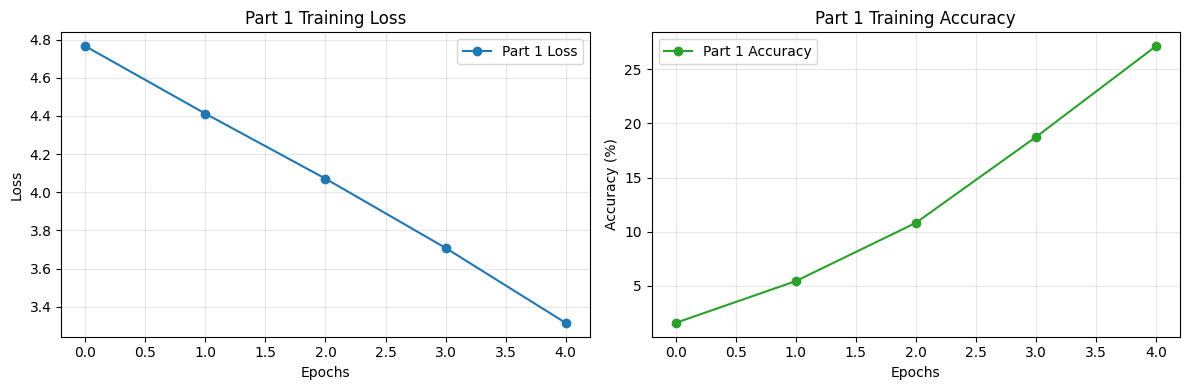


🚀 STARTING TRAINING FOR PART 2 / 5
--- Starting Training for Part2 ---


Epoch 1/5: 100%|██████████| 850/850 [24:37<00:00,  1.74s/it, loss=4.79]


Epoch 1: Loss=4.8085, Acc=1.28%


Epoch 2/5: 100%|██████████| 850/850 [24:41<00:00,  1.74s/it, loss=4.57]


Epoch 2: Loss=4.5862, Acc=5.15%


Epoch 3/5: 100%|██████████| 850/850 [24:42<00:00,  1.74s/it, loss=4.03]


Epoch 3: Loss=4.1656, Acc=9.31%


Epoch 4/5: 100%|██████████| 850/850 [24:40<00:00,  1.74s/it, loss=3.79]


Epoch 4: Loss=3.7988, Acc=15.47%


Epoch 5/5: 100%|██████████| 850/850 [24:36<00:00,  1.74s/it, loss=2.45]


Epoch 5: Loss=3.5014, Acc=20.53%


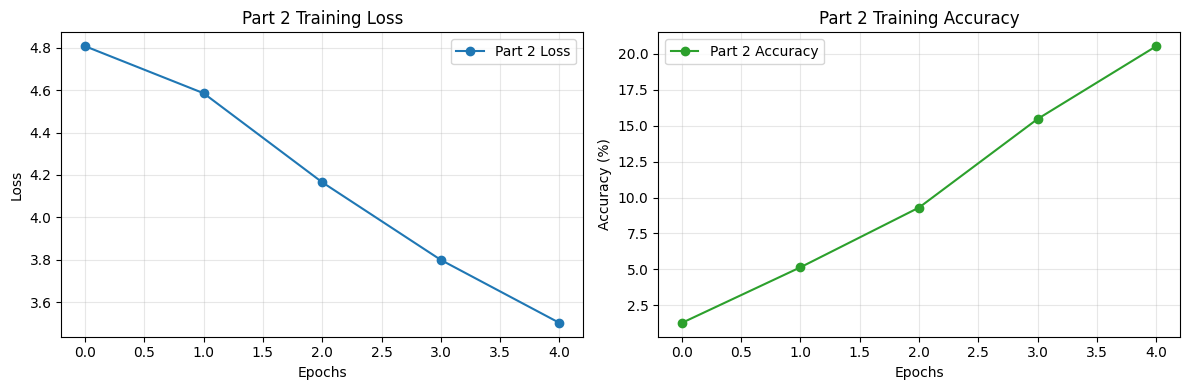


🚀 STARTING TRAINING FOR PART 3 / 5
--- Starting Training for Part3 ---


Epoch 1/5: 100%|██████████| 850/850 [24:42<00:00,  1.74s/it, loss=4.7]


Epoch 1: Loss=4.8294, Acc=0.94%


Epoch 2/5: 100%|██████████| 850/850 [24:45<00:00,  1.75s/it, loss=4.75]


Epoch 2: Loss=4.7302, Acc=2.85%


Epoch 3/5: 100%|██████████| 850/850 [24:42<00:00,  1.74s/it, loss=4.25]


Epoch 3: Loss=4.4634, Acc=6.94%


Epoch 4/5: 100%|██████████| 850/850 [24:48<00:00,  1.75s/it, loss=3.91]


Epoch 4: Loss=4.1354, Acc=10.76%


Epoch 5/5: 100%|██████████| 850/850 [24:43<00:00,  1.75s/it, loss=3.59]


Epoch 5: Loss=3.8254, Acc=15.24%


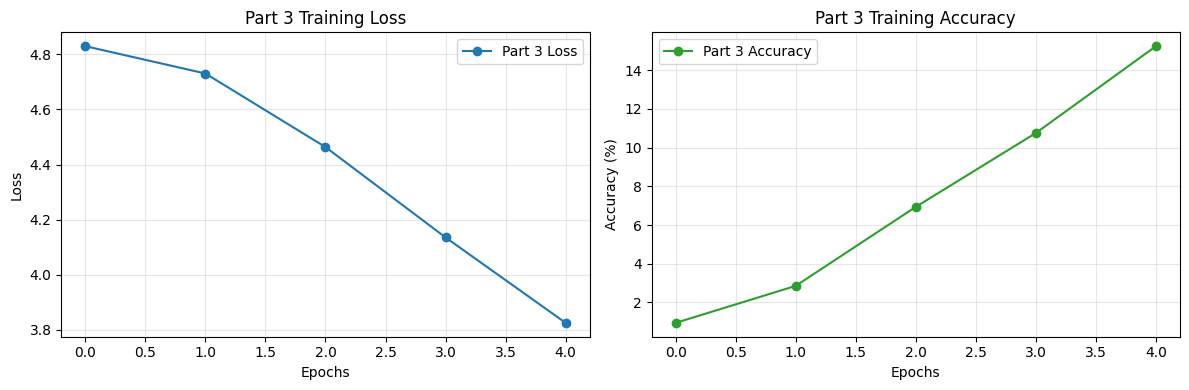


🚀 STARTING TRAINING FOR PART 4 / 5
--- Starting Training for Part4 ---


Epoch 1/5: 100%|██████████| 850/850 [24:45<00:00,  1.75s/it, loss=4.75]


Epoch 1: Loss=4.8267, Acc=1.01%


Epoch 2/5: 100%|██████████| 850/850 [24:48<00:00,  1.75s/it, loss=4.72]


Epoch 2: Loss=4.7446, Acc=2.86%


Epoch 3/5: 100%|██████████| 850/850 [24:50<00:00,  1.75s/it, loss=4.29]


Epoch 3: Loss=4.5265, Acc=6.36%


Epoch 4/5: 100%|██████████| 850/850 [24:44<00:00,  1.75s/it, loss=4.13]


Epoch 4: Loss=4.1716, Acc=9.99%


Epoch 5/5: 100%|██████████| 850/850 [24:47<00:00,  1.75s/it, loss=3.76]


Epoch 5: Loss=3.8494, Acc=13.43%


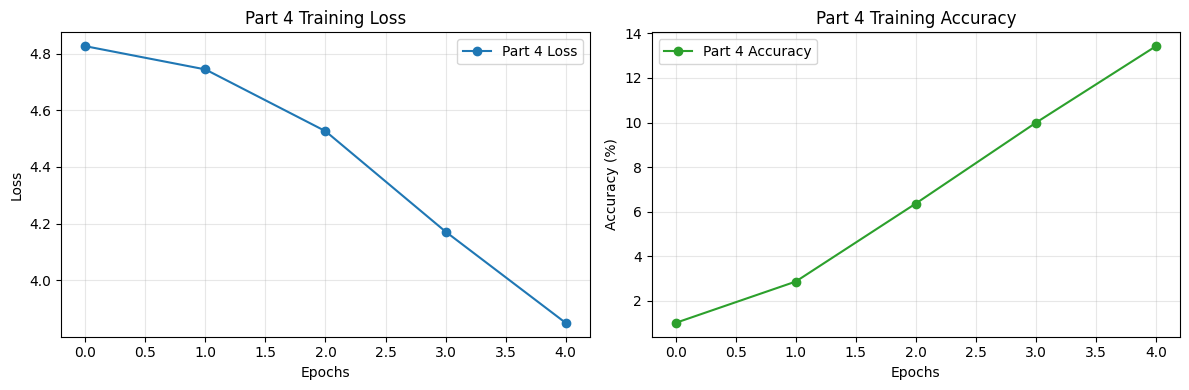


🚀 STARTING TRAINING FOR PART 5 / 5
--- Starting Training for Part5 ---


Epoch 1/5: 100%|██████████| 850/850 [24:46<00:00,  1.75s/it, loss=4.87]


Epoch 1: Loss=4.8388, Acc=0.77%


Epoch 2/5: 100%|██████████| 850/850 [24:47<00:00,  1.75s/it, loss=4.68]


Epoch 2: Loss=4.7972, Acc=1.43%


Epoch 3/5: 100%|██████████| 850/850 [24:43<00:00,  1.75s/it, loss=4.57]


Epoch 3: Loss=4.6797, Acc=2.88%


Epoch 4/5: 100%|██████████| 850/850 [24:52<00:00,  1.76s/it, loss=4.29]


Epoch 4: Loss=4.5191, Acc=4.72%


Epoch 5/5:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 5/5: 100%|██████████| 850/850 [24:44<00:00,  1.75s/it, loss=4.22]


Epoch 5: Loss=4.3211, Acc=7.07%


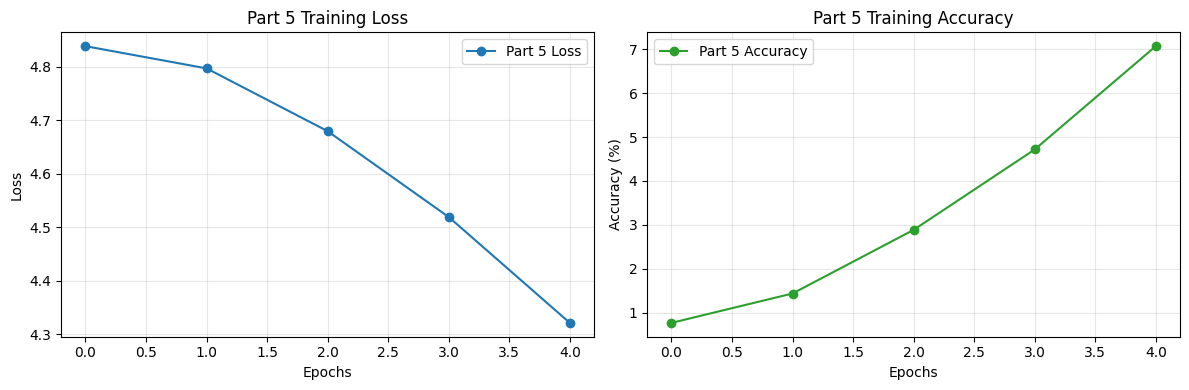


✅ All 5 Parts have been successfully trained and stored!


In [ ]:
# @title 7. Loop Training for All 5 Parts
# This cell trains a fresh model for each body part (Head, Chest, Waist, Thighs, Legs)
# It plots the results immediately and saves the models for the next steps.

# 1. Initialize storage for our results
trained_models = {}      # To store the 5 trained model objects
data_loaders = {}        # To store the 5 dataloaders (needed for fusion evaluation)
training_results = {}    # To store loss and accuracy lists

# 2. Loop from Part 1 to Part 5
for part_id in range(1, 6):
    print(f"\n{'='*60}")
    print(f"🚀 STARTING TRAINING FOR PART {part_id} / 5")
    print(f"{'='*60}")

    # A. Load Dataset for specific part
    # We create a new dataset object pointing to the specific PART_X folder
    dataset = GaitPartDataset(OUTPUT_PARTS_DIR, part_id=part_id, transform=data_transforms)

    # B. Create DataLoader
    # num_workers=2 and pin_memory=True speeds up data transfer to GPU
    loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

    # C. Initialize FRESH Model
    # IMPORTANT: We initialize a NEW model every time.
    # If we didn't, Part 2 would start with Part 1's weights (Catastrophic Forgetting).
    # Switch to GaitConvNeXt(num_classes=124) here if you want the heavier model.
    model = GaitConvNeXt(num_classes=124)

    # D. Train
    # This calls your train_model function defined earlier
    losses, accs = train_model(model, loader, epochs=5, part_name=f"Part{part_id}")

    # E. Store everything for later use
    trained_models[part_id] = model
    data_loaders[part_id] = loader
    training_results[part_id] = {'loss': losses, 'acc': accs}

    # F. Plot Training Curves immediately
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(losses, label=f'Part {part_id} Loss', color='tab:blue', marker='o')
    plt.title(f'Part {part_id} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(accs, label=f'Part {part_id} Accuracy', color='tab:green', marker='o')
    plt.title(f'Part {part_id} Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\n✅ All 5 Parts have been successfully trained and stored!")

In [ ]:
# Save models, loaders & results into files to fetch easier later
import pickle

# Save trained models
with open('trained_models.pkl', 'wb') as f:
    pickle.dump((trained_models, data_loaders, training_results), f)
    print("✅ Models saved to 'trained_models.pkl'")

✅ Models saved to 'trained_models.pkl'



📊 EVALUATING PART 1


Evaluating Part 1:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Part 1 Test Accuracy: 36.27%


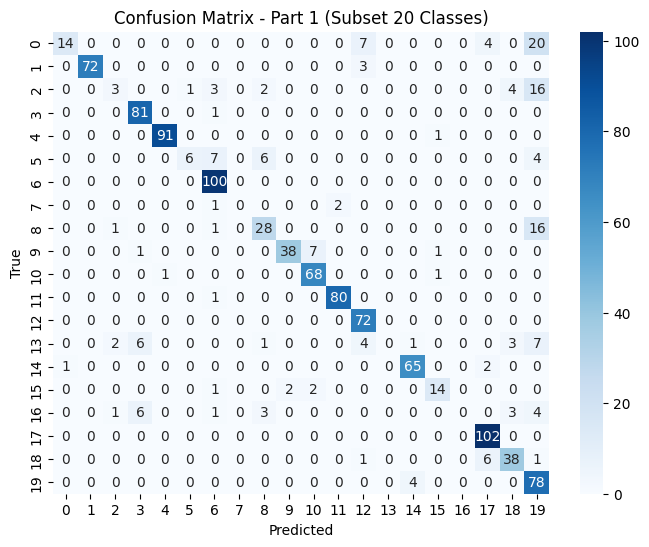


📊 EVALUATING PART 2


Evaluating Part 2:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Part 2 Test Accuracy: 28.71%


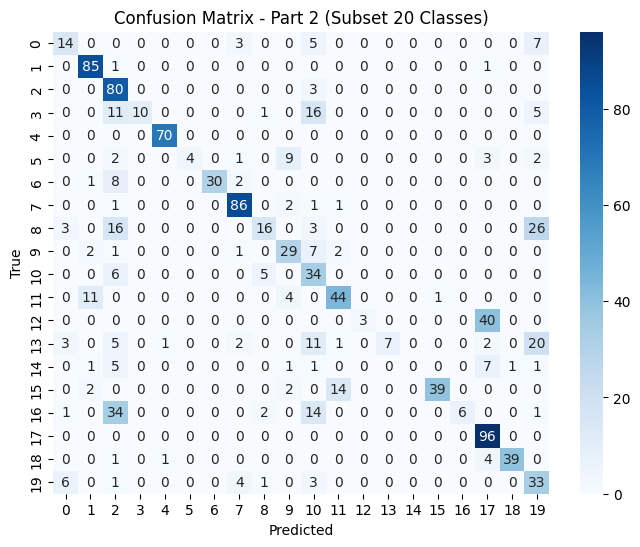


📊 EVALUATING PART 3


Evaluating Part 3:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Part 3 Test Accuracy: 21.13%


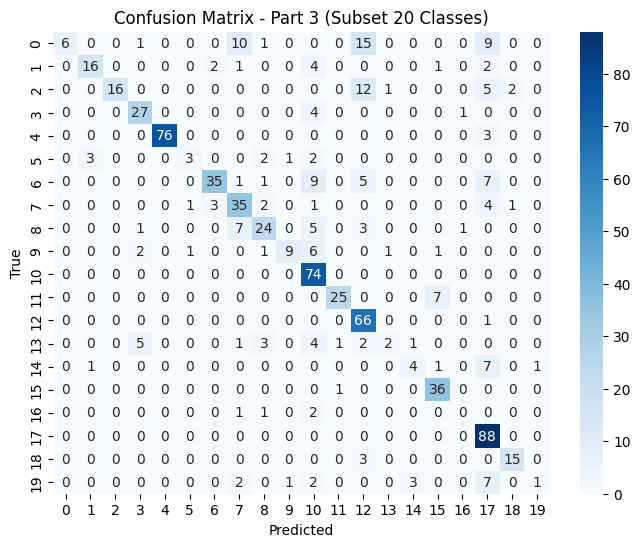


📊 EVALUATING PART 4


Evaluating Part 4:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Part 4 Test Accuracy: 19.81%


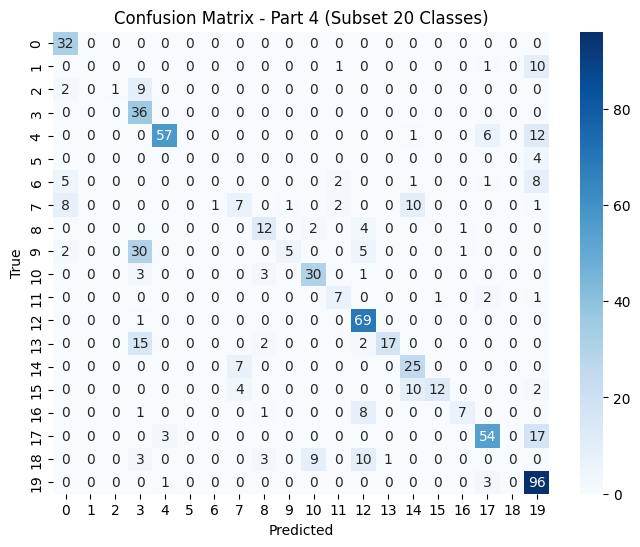


📊 EVALUATING PART 5


Evaluating Part 5:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Part 5 Test Accuracy: 10.51%


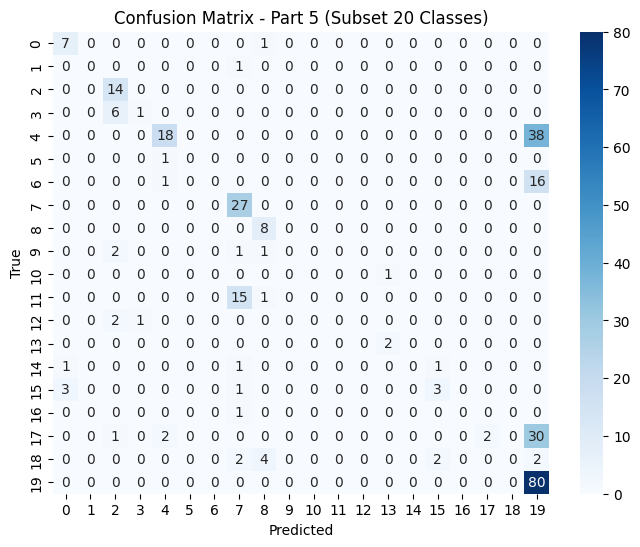


🏆 INDIVIDUAL PART ACCURACIES
Part 1: 36.27%
Part 2: 28.71%
Part 3: 21.13%
Part 4: 19.81%
Part 5: 10.51%


In [ ]:
# @title 8. Loop Evaluation for All 5 Parts
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader, part_name="Part"):
    model.eval()
    all_preds = []
    all_labels = []

    # Disable gradient calculation for speed
    with torch.no_grad():
        # leave=False keeps the progress bar from cluttering the output
        for images, labels in tqdm(dataloader, desc=f"Evaluating {part_name}", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ {part_name} Test Accuracy: {acc*100:.2f}%")

    # Optional: Print report for first few classes to check precision/recall
    # print(classification_report(all_labels, all_preds, labels=list(range(5))))

    return all_labels, all_preds, acc

# Dictionary to store final accuracies for summary
part_accuracies = {}

# --- MAIN EVALUATION LOOP ---
for part_id in range(1, 6):
    print(f"\n{'='*40}")
    print(f"📊 EVALUATING PART {part_id}")
    print(f"{'='*40}")

    # Check if model exists (safety check)
    if part_id not in trained_models:
        print(f"⚠️ Model for Part {part_id} not found. Did you run the training loop?")
        continue

    # Retrieve the specific model and dataloader for this part
    model = trained_models[part_id]
    loader = data_loaders[part_id]

    # Run Evaluation
    true_labels, pred_labels, acc = evaluate_model(model, loader, part_name=f"Part {part_id}")
    part_accuracies[part_id] = acc

    # Plot Confusion Matrix
    # We only show the first 20 classes to keep the plot readable
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Part {part_id} (Subset 20 Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# --- FINAL SUMMARY ---
print("\n" + "="*30)
print("🏆 INDIVIDUAL PART ACCURACIES")
print("="*30)
for pid, acc in part_accuracies.items():
    print(f"Part {pid}: {acc*100:.2f}%")

In [ ]:
# @title 9. Full Ensemble Evaluation (Fusion of 5 Parts)
# This cell simulates the final evaluation by combining features from all 5 parts.

def extract_feature(model, image_tensor):
    """
    Extracts the 1024-dim embedding vector from the model
    (Removing the final classification layer)
    """
    model.eval()
    with torch.no_grad():
        # Get features from the layer before the final classifier
        # For ConvNeXt, we hook into the classifier or just run the base
        features = model.base_model.forward(image_tensor.unsqueeze(0).to(device))
        # Depending on implementation, you might need to flatten
        return features.cpu().flatten().numpy()

def evaluate_fusion(models_list, test_loader_list):
    """
    models_list: List of 5 trained models (Part 1 to Part 5)
    test_loader_list: List of 5 dataloaders (Part 1 to Part 5)
    """
    print("Starting Fusion Evaluation...")

    # We assume all loaders have the same order of images (aligned)
    # We will simulate Probe vs Gallery matching

    correct_identifications = 0
    total_probes = 0

    # Iterate through the dataset (batch_size=1 for simplicity in evaluation)
    # In a real scenario, you split this into Gallery (first 4 walks) and Probe (last 2 walks)

    # Placeholder for feature vectors
    gallery_features = [] # List of (ID, fused_vector)
    probe_features = []   # List of (ID, fused_vector)

    # 1. Extract Features
    # We loop through ONE loader to get indices, but pull images from ALL 5 loaders
    # Use the first dataloader from the list to get the total number of samples
    loader_ref = test_loader_list[0]

    print("Extracting features from all 5 parts...")
    for i in tqdm(range(len(loader_ref.dataset))):

        # Get the same image index from all 5 parts
        part_vectors = []
        label = None

        for part_idx in range(5):
            # Access models and loaders by their 0-indexed position corresponding to Part 1-5
            img, lbl = test_loader_list[part_idx].dataset[i]
            model = models_list[part_idx]

            # Extract feature
            vec = extract_feature(model, img)
            part_vectors.append(vec)
            label = lbl.item()

        # FUSION: Concatenate the 5 vectors
        # Shape becomes (1024 * 5) = 5120 dimensions
        fused_vector = np.concatenate(part_vectors)

        # Determine if Gallery (Normal-01 to Normal-04) or Probe (Normal-05, Normal-06)
        # This requires parsing the filename from the dataset
        # For this simplified demo, we'll split randomly 50/50
        if i % 2 == 0:
            gallery_features.append((label, fused_vector))
        else:
            probe_features.append((label, fused_vector))

    # 2. Matching (Cosine Similarity)
    print(f"Matching {len(probe_features)} Probes against {len(gallery_features)} Gallery items...")

    for probe_id, probe_vec in tqdm(probe_features):
        best_score = -1.0
        best_match_id = -1

        for gal_id, gal_vec in gallery_features:
            # Cosine Similarity Formula
            score = np.dot(probe_vec, gal_vec) / (np.linalg.norm(probe_vec) * np.linalg.norm(gal_vec))

            if score > best_score:
                best_score = score
                best_match_id = gal_id

        if best_match_id == probe_id:
            correct_identifications += 1
        total_probes += 1

    rank1_acc = correct_identifications / total_probes
    print(f"\n🏆 Final Ensemble Rank-1 Accuracy: {rank1_acc*100:.2f}%")

# --- HOW TO RUN THIS ---
# Convert the dictionaries to ordered lists for evaluation
enumerated_trained_models = [trained_models[i] for i in range(1, 6)]
enumerated_data_loaders = [data_loaders[i] for i in range(1, 6)]

evaluate_fusion(enumerated_trained_models, enumerated_data_loaders)

Starting Fusion Evaluation...
Extracting features from all 5 parts...


100%|██████████| 13592/13592 [1:00:32<00:00,  3.74it/s]


Matching 6796 Probes against 6796 Gallery items...


100%|██████████| 6796/6796 [03:11<00:00, 35.58it/s]


🏆 Final Ensemble Rank-1 Accuracy: 92.26%


In [ ]:
# @title 5. Define Lighter Deep Learning Model (ResNet18)
import torchvision.models as models

class GaitResNet(nn.Module):
    def __init__(self, num_classes=124):
        super(GaitResNet, self).__init__()

        # Load Pretrained ResNet18
        # "weights='DEFAULT'" downloads the best available weights from ImageNet
        self.base_model = models.resnet18(weights='DEFAULT')

        # Modify the final classification layer
        # ResNet18's last layer is named 'fc' and has 512 input features
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# @title 10. Train Ensemble (Bootstrapping)
# The paper trains 5 identical models on different data splits for EACH part.

def get_bootstrap_loader(dataset, batch_size=16):
    """
    Creates a DataLoader that samples with replacement (Bagging).
    """
    num_samples = len(dataset)
    # Random indices with replacement (some images appear twice, some never)
    indices = np.random.choice(num_samples, num_samples, replace=True)

    sampler = torch.utils.data.SubsetRandomSampler(indices)
    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                        num_workers=2, pin_memory=True)
    return loader

# Dictionary to store ensemble model paths for all parts
all_ensemble_paths = {}

for part_id_loop in range(1, 6):
  PART_ID = part_id_loop
  dataset_ens = GaitPartDataset(OUTPUT_PARTS_DIR, part_id=PART_ID, transform=data_transforms)

  ensemble_paths_current_part = []

  print(f"--- Training Ensemble for PART {PART_ID} ---")

  for i_ens in range(5):
      print(f"\nTraining Ensemble Member {i_ens+1}/5...")

      # 1. Create Bootstrap Loader (New data split every time)
      train_loader = get_bootstrap_loader(dataset_ens)

      # 2. Initialize FRESH model
      model = GaitResNet(num_classes=124)

      # 3. Train (Using fewer epochs for demo speed, paper uses ~30)
      train_model(model, train_loader, epochs=5, part_name=f"Part{PART_ID}_Ens{i_ens+1}")

      # 4. Save
      save_path = f"model_Part{PART_ID}_Ens{i_ens+1}.pth"
      torch.save(model.state_dict(), save_path)
      ensemble_paths_current_part.append(save_path)

  all_ensemble_paths[PART_ID] = ensemble_paths_current_part
  print(f"\n✅ Trained 5 Ensemble Models for Part {PART_ID}: {ensemble_paths_current_part}")

--- Training Ensemble for PART 1 ---

Training Ensemble Member 1/5...
--- Starting Training for Part1_Ens1 ---


Epoch 1/5:   0%|          | 0/850 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/5: 100%|██████████| 850/850 [02:19<00:00,  6.08it/s, loss=4.15]


Epoch 1: Loss=4.6412, Acc=5.67%


Epoch 2/5: 100%|██████████| 850/850 [02:14<00:00,  6.30it/s, loss=3.83]


Epoch 2: Loss=4.0607, Acc=20.49%


Epoch 3/5: 100%|██████████| 850/850 [02:15<00:00,  6.28it/s, loss=3.89]


Epoch 3: Loss=3.5397, Acc=34.98%


Epoch 4/5: 100%|██████████| 850/850 [02:20<00:00,  6.04it/s, loss=2.59]


Epoch 4: Loss=3.0767, Acc=46.31%


Epoch 5/5: 100%|██████████| 850/850 [02:17<00:00,  6.20it/s, loss=2.57]


Epoch 5: Loss=2.6656, Acc=55.64%

Training Ensemble Member 2/5...
--- Starting Training for Part1_Ens2 ---


Epoch 1/5: 100%|██████████| 850/850 [02:18<00:00,  6.15it/s, loss=4.32]


Epoch 1: Loss=4.6748, Acc=4.95%


Epoch 2/5: 100%|██████████| 850/850 [02:18<00:00,  6.12it/s, loss=3.8]


Epoch 2: Loss=4.0968, Acc=21.11%


Epoch 3/5: 100%|██████████| 850/850 [02:20<00:00,  6.07it/s, loss=3.48]


Epoch 3: Loss=3.5629, Acc=35.84%


Epoch 4/5: 100%|██████████| 850/850 [02:13<00:00,  6.36it/s, loss=2.67]


Epoch 4: Loss=3.0811, Acc=47.85%


Epoch 5/5: 100%|██████████| 850/850 [02:16<00:00,  6.21it/s, loss=2.53]


Epoch 5: Loss=2.6612, Acc=57.53%

Training Ensemble Member 3/5...
--- Starting Training for Part1_Ens3 ---


Epoch 1/5: 100%|██████████| 850/850 [02:16<00:00,  6.22it/s, loss=4.11]


Epoch 1: Loss=4.6367, Acc=5.48%


Epoch 2/5: 100%|██████████| 850/850 [02:16<00:00,  6.22it/s, loss=3.65]


Epoch 2: Loss=4.0405, Acc=20.67%


Epoch 3/5: 100%|██████████| 850/850 [02:18<00:00,  6.13it/s, loss=3.24]


Epoch 3: Loss=3.5211, Acc=35.15%


Epoch 4/5: 100%|██████████| 850/850 [02:14<00:00,  6.33it/s, loss=3.08]


Epoch 4: Loss=3.0618, Acc=46.70%


Epoch 5/5: 100%|██████████| 850/850 [02:14<00:00,  6.32it/s, loss=2.66]


Epoch 5: Loss=2.6540, Acc=56.03%

Training Ensemble Member 4/5...
--- Starting Training for Part1_Ens4 ---


Epoch 1/5: 100%|██████████| 850/850 [02:18<00:00,  6.15it/s, loss=4.45]


Epoch 1: Loss=4.6513, Acc=5.67%


Epoch 2/5: 100%|██████████| 850/850 [02:19<00:00,  6.10it/s, loss=3.88]


Epoch 2: Loss=4.0698, Acc=20.23%


Epoch 3/5: 100%|██████████| 850/850 [02:17<00:00,  6.17it/s, loss=3.74]


Epoch 3: Loss=3.5774, Acc=33.12%


Epoch 4/5: 100%|██████████| 850/850 [02:19<00:00,  6.10it/s, loss=3.35]


Epoch 4: Loss=3.1431, Acc=43.93%


Epoch 5/5: 100%|██████████| 850/850 [02:13<00:00,  6.34it/s, loss=2.35]


Epoch 5: Loss=2.7451, Acc=53.24%

Training Ensemble Member 5/5...
--- Starting Training for Part1_Ens5 ---


Epoch 1/5: 100%|██████████| 850/850 [02:16<00:00,  6.22it/s, loss=4.15]


Epoch 1: Loss=4.6467, Acc=5.63%


Epoch 2/5: 100%|██████████| 850/850 [02:17<00:00,  6.19it/s, loss=3.99]


Epoch 2: Loss=4.0473, Acc=21.93%


Epoch 3/5: 100%|██████████| 850/850 [02:16<00:00,  6.21it/s, loss=3.36]


Epoch 3: Loss=3.5264, Acc=37.21%


Epoch 4/5: 100%|██████████| 850/850 [02:16<00:00,  6.24it/s, loss=2.91]


Epoch 4: Loss=3.0654, Acc=48.18%


Epoch 5/5: 100%|██████████| 850/850 [02:14<00:00,  6.34it/s, loss=2.42]


Epoch 5: Loss=2.6544, Acc=56.81%

✅ Trained 5 Ensemble Models for Part 1: ['model_Part1_Ens1.pth', 'model_Part1_Ens2.pth', 'model_Part1_Ens3.pth', 'model_Part1_Ens4.pth', 'model_Part1_Ens5.pth']
--- Training Ensemble for PART 2 ---

Training Ensemble Member 1/5...
--- Starting Training for Part2_Ens1 ---


Epoch 1/5: 100%|██████████| 850/850 [02:24<00:00,  5.87it/s, loss=4.57]


Epoch 1: Loss=4.6946, Acc=4.24%


Epoch 2/5: 100%|██████████| 850/850 [02:23<00:00,  5.91it/s, loss=3.71]


Epoch 2: Loss=4.1794, Acc=15.46%


Epoch 3/5: 100%|██████████| 850/850 [02:21<00:00,  6.01it/s, loss=3.25]


Epoch 3: Loss=3.7314, Acc=26.32%


Epoch 4/5: 100%|██████████| 850/850 [02:24<00:00,  5.90it/s, loss=3.02]


Epoch 4: Loss=3.3459, Acc=35.43%


Epoch 5/5: 100%|██████████| 850/850 [02:21<00:00,  6.02it/s, loss=3.02]


Epoch 5: Loss=3.0082, Acc=44.11%

Training Ensemble Member 2/5...
--- Starting Training for Part2_Ens2 ---


Epoch 1/5: 100%|██████████| 850/850 [02:20<00:00,  6.03it/s, loss=4.64]


Epoch 1: Loss=4.7385, Acc=2.97%


Epoch 2/5: 100%|██████████| 850/850 [02:21<00:00,  5.99it/s, loss=4.19]


Epoch 2: Loss=4.2510, Acc=11.26%


Epoch 3/5: 100%|██████████| 850/850 [02:18<00:00,  6.12it/s, loss=3.71]


Epoch 3: Loss=3.8211, Acc=22.90%


Epoch 4/5: 100%|██████████| 850/850 [02:23<00:00,  5.91it/s, loss=3.49]


Epoch 4: Loss=3.4448, Acc=33.41%


Epoch 5/5: 100%|██████████| 850/850 [02:19<00:00,  6.11it/s, loss=3.8]


Epoch 5: Loss=3.1297, Acc=42.19%

Training Ensemble Member 3/5...
--- Starting Training for Part2_Ens3 ---


Epoch 1/5: 100%|██████████| 850/850 [02:21<00:00,  5.99it/s, loss=4.76]


Epoch 1: Loss=4.7307, Acc=2.89%


Epoch 2/5: 100%|██████████| 850/850 [02:19<00:00,  6.07it/s, loss=4.42]


Epoch 2: Loss=4.2532, Acc=13.38%


Epoch 3/5: 100%|██████████| 850/850 [02:24<00:00,  5.89it/s, loss=3.84]


Epoch 3: Loss=3.8146, Acc=24.83%


Epoch 4/5: 100%|██████████| 850/850 [02:19<00:00,  6.09it/s, loss=3.44]


Epoch 4: Loss=3.4198, Acc=34.76%


Epoch 5/5: 100%|██████████| 850/850 [02:17<00:00,  6.17it/s, loss=3.09]


Epoch 5: Loss=3.0809, Acc=42.34%

Training Ensemble Member 4/5...
--- Starting Training for Part2_Ens4 ---


Epoch 1/5: 100%|██████████| 850/850 [02:21<00:00,  6.03it/s, loss=4.26]


Epoch 1: Loss=4.6977, Acc=3.83%


Epoch 2/5: 100%|██████████| 850/850 [02:25<00:00,  5.84it/s, loss=3.99]


Epoch 2: Loss=4.2141, Acc=14.32%


Epoch 3/5: 100%|██████████| 850/850 [02:20<00:00,  6.04it/s, loss=3.95]


Epoch 3: Loss=3.7819, Acc=24.34%


Epoch 4/5: 100%|██████████| 850/850 [02:19<00:00,  6.11it/s, loss=2.93]


Epoch 4: Loss=3.4085, Acc=34.95%


Epoch 5/5: 100%|██████████| 850/850 [02:21<00:00,  6.03it/s, loss=3.32]


Epoch 5: Loss=3.0841, Acc=42.54%

Training Ensemble Member 5/5...
--- Starting Training for Part2_Ens5 ---


Epoch 1/5: 100%|██████████| 850/850 [02:20<00:00,  6.04it/s, loss=4.61]


Epoch 1: Loss=4.7174, Acc=3.58%


Epoch 2/5: 100%|██████████| 850/850 [02:18<00:00,  6.15it/s, loss=3.78]


Epoch 2: Loss=4.2363, Acc=13.74%


Epoch 3/5: 100%|██████████| 850/850 [02:20<00:00,  6.05it/s, loss=3.91]


Epoch 3: Loss=3.7976, Acc=24.15%


Epoch 4/5: 100%|██████████| 850/850 [02:17<00:00,  6.20it/s, loss=3.2]


Epoch 4: Loss=3.4180, Acc=34.05%


Epoch 5/5: 100%|██████████| 850/850 [02:20<00:00,  6.06it/s, loss=3.46]


Epoch 5: Loss=3.0864, Acc=42.14%

✅ Trained 5 Ensemble Models for Part 2: ['model_Part2_Ens1.pth', 'model_Part2_Ens2.pth', 'model_Part2_Ens3.pth', 'model_Part2_Ens4.pth', 'model_Part2_Ens5.pth']
--- Training Ensemble for PART 3 ---

Training Ensemble Member 1/5...
--- Starting Training for Part3_Ens1 ---


Epoch 1/5: 100%|██████████| 850/850 [02:19<00:00,  6.07it/s, loss=4.66]


Epoch 1: Loss=4.7777, Acc=2.38%


Epoch 2/5: 100%|██████████| 850/850 [02:23<00:00,  5.93it/s, loss=4.58]


Epoch 2: Loss=4.4011, Acc=12.18%


Epoch 3/5: 100%|██████████| 850/850 [02:21<00:00,  6.01it/s, loss=3.97]


Epoch 3: Loss=3.9921, Acc=23.49%


Epoch 4/5: 100%|██████████| 850/850 [02:21<00:00,  5.99it/s, loss=3.54]


Epoch 4: Loss=3.6061, Acc=33.03%


Epoch 5/5: 100%|██████████| 850/850 [02:18<00:00,  6.13it/s, loss=3.28]


Epoch 5: Loss=3.2489, Acc=42.59%

Training Ensemble Member 2/5...
--- Starting Training for Part3_Ens2 ---


Epoch 1/5: 100%|██████████| 850/850 [02:29<00:00,  5.68it/s, loss=4.54]


Epoch 1: Loss=4.7156, Acc=4.02%


Epoch 2/5: 100%|██████████| 850/850 [02:28<00:00,  5.74it/s, loss=4.41]


Epoch 2: Loss=4.2599, Acc=14.39%


Epoch 3/5: 100%|██████████| 850/850 [02:26<00:00,  5.79it/s, loss=3.81]


Epoch 3: Loss=3.8414, Acc=26.71%


Epoch 4/5: 100%|██████████| 850/850 [02:26<00:00,  5.82it/s, loss=3.34]


Epoch 4: Loss=3.4693, Acc=35.79%


Epoch 5/5: 100%|██████████| 850/850 [02:23<00:00,  5.92it/s, loss=3.02]


Epoch 5: Loss=3.1339, Acc=43.25%

Training Ensemble Member 3/5...
--- Starting Training for Part3_Ens3 ---


Epoch 1/5: 100%|██████████| 850/850 [02:25<00:00,  5.86it/s, loss=4.46]


Epoch 1: Loss=4.7178, Acc=3.57%


Epoch 2/5: 100%|██████████| 850/850 [02:24<00:00,  5.88it/s, loss=4.21]


Epoch 2: Loss=4.2670, Acc=13.93%


Epoch 3/5: 100%|██████████| 850/850 [02:25<00:00,  5.85it/s, loss=3.47]


Epoch 3: Loss=3.8577, Acc=23.54%


Epoch 4/5: 100%|██████████| 850/850 [02:23<00:00,  5.91it/s, loss=3.3]


Epoch 4: Loss=3.4970, Acc=32.76%


Epoch 5/5: 100%|██████████| 850/850 [02:29<00:00,  5.69it/s, loss=3.3]


Epoch 5: Loss=3.1709, Acc=41.10%

Training Ensemble Member 4/5...
--- Starting Training for Part3_Ens4 ---


Epoch 1/5: 100%|██████████| 850/850 [02:24<00:00,  5.89it/s, loss=4.59]


Epoch 1: Loss=4.7499, Acc=3.02%


Epoch 2/5: 100%|██████████| 850/850 [02:22<00:00,  5.98it/s, loss=4.63]


Epoch 2: Loss=4.3329, Acc=12.53%


Epoch 3/5: 100%|██████████| 850/850 [02:20<00:00,  6.05it/s, loss=4.17]


Epoch 3: Loss=3.9204, Acc=23.03%


Epoch 4/5: 100%|██████████| 850/850 [02:19<00:00,  6.08it/s, loss=3.07]


Epoch 4: Loss=3.5431, Acc=34.76%


Epoch 5/5: 100%|██████████| 850/850 [02:20<00:00,  6.06it/s, loss=3.17]


Epoch 5: Loss=3.2070, Acc=43.39%

Training Ensemble Member 5/5...
--- Starting Training for Part3_Ens5 ---


Epoch 1/5: 100%|██████████| 850/850 [02:28<00:00,  5.72it/s, loss=4.27]


Epoch 1: Loss=4.7201, Acc=3.29%


Epoch 2/5: 100%|██████████| 850/850 [02:27<00:00,  5.76it/s, loss=4.01]


Epoch 2: Loss=4.3224, Acc=13.34%


Epoch 3/5: 100%|██████████| 850/850 [02:22<00:00,  5.95it/s, loss=4.05]


Epoch 3: Loss=3.9422, Acc=23.51%


Epoch 4/5: 100%|██████████| 850/850 [02:24<00:00,  5.89it/s, loss=3.63]


Epoch 4: Loss=3.5894, Acc=32.11%


Epoch 5/5: 100%|██████████| 850/850 [02:23<00:00,  5.93it/s, loss=3.54]


Epoch 5: Loss=3.2496, Acc=42.16%

✅ Trained 5 Ensemble Models for Part 3: ['model_Part3_Ens1.pth', 'model_Part3_Ens2.pth', 'model_Part3_Ens3.pth', 'model_Part3_Ens4.pth', 'model_Part3_Ens5.pth']
--- Training Ensemble for PART 4 ---

Training Ensemble Member 1/5...
--- Starting Training for Part4_Ens1 ---


Epoch 1/5: 100%|██████████| 850/850 [02:22<00:00,  5.97it/s, loss=4.52]


Epoch 1: Loss=4.7314, Acc=3.13%


Epoch 2/5: 100%|██████████| 850/850 [02:24<00:00,  5.88it/s, loss=3.98]


Epoch 2: Loss=4.2949, Acc=11.18%


Epoch 3/5: 100%|██████████| 850/850 [02:21<00:00,  5.99it/s, loss=3.52]


Epoch 3: Loss=3.8862, Acc=21.37%


Epoch 4/5: 100%|██████████| 850/850 [02:19<00:00,  6.08it/s, loss=3.24]


Epoch 4: Loss=3.5098, Acc=32.29%


Epoch 5/5: 100%|██████████| 850/850 [02:23<00:00,  5.91it/s, loss=2.91]


Epoch 5: Loss=3.1693, Acc=41.39%

Training Ensemble Member 2/5...
--- Starting Training for Part4_Ens2 ---


Epoch 1/5: 100%|██████████| 850/850 [02:21<00:00,  6.02it/s, loss=4.46]


Epoch 1: Loss=4.7647, Acc=2.77%


Epoch 2/5: 100%|██████████| 850/850 [02:20<00:00,  6.06it/s, loss=3.83]


Epoch 2: Loss=4.3569, Acc=10.70%


Epoch 3/5: 100%|██████████| 850/850 [02:17<00:00,  6.16it/s, loss=4.11]


Epoch 3: Loss=3.9347, Acc=19.48%


Epoch 4/5: 100%|██████████| 850/850 [02:21<00:00,  6.00it/s, loss=4]


Epoch 4: Loss=3.5518, Acc=29.77%


Epoch 5/5: 100%|██████████| 850/850 [02:24<00:00,  5.87it/s, loss=3.69]


Epoch 5: Loss=3.1978, Acc=39.38%

Training Ensemble Member 3/5...
--- Starting Training for Part4_Ens3 ---


Epoch 1/5: 100%|██████████| 850/850 [02:16<00:00,  6.21it/s, loss=4.69]


Epoch 1: Loss=4.7340, Acc=3.23%


Epoch 2/5: 100%|██████████| 850/850 [02:16<00:00,  6.21it/s, loss=4.55]


Epoch 2: Loss=4.2954, Acc=12.03%


Epoch 3/5: 100%|██████████| 850/850 [02:16<00:00,  6.22it/s, loss=4.03]


Epoch 3: Loss=3.8687, Acc=21.55%


Epoch 4/5: 100%|██████████| 850/850 [02:18<00:00,  6.15it/s, loss=3.38]


Epoch 4: Loss=3.4848, Acc=31.57%


Epoch 5/5: 100%|██████████| 850/850 [02:17<00:00,  6.18it/s, loss=3.16]


Epoch 5: Loss=3.1406, Acc=41.39%

Training Ensemble Member 4/5...
--- Starting Training for Part4_Ens4 ---


Epoch 1/5: 100%|██████████| 850/850 [02:18<00:00,  6.12it/s, loss=4.52]


Epoch 1: Loss=4.7607, Acc=2.54%


Epoch 2/5: 100%|██████████| 850/850 [02:17<00:00,  6.16it/s, loss=4.31]


Epoch 2: Loss=4.3514, Acc=11.17%


Epoch 3/5: 100%|██████████| 850/850 [02:24<00:00,  5.88it/s, loss=3.53]


Epoch 3: Loss=3.9500, Acc=19.95%


Epoch 4/5: 100%|██████████| 850/850 [02:19<00:00,  6.08it/s, loss=3.47]


Epoch 4: Loss=3.5983, Acc=28.27%


Epoch 5/5: 100%|██████████| 850/850 [02:17<00:00,  6.16it/s, loss=3]


Epoch 5: Loss=3.2714, Acc=36.68%

Training Ensemble Member 5/5...
--- Starting Training for Part4_Ens5 ---


Epoch 1/5: 100%|██████████| 850/850 [02:15<00:00,  6.29it/s, loss=4.51]


Epoch 1: Loss=4.7577, Acc=2.86%


Epoch 2/5: 100%|██████████| 850/850 [02:18<00:00,  6.13it/s, loss=4.31]


Epoch 2: Loss=4.3511, Acc=10.38%


Epoch 3/5: 100%|██████████| 850/850 [02:15<00:00,  6.28it/s, loss=3.89]


Epoch 3: Loss=3.9378, Acc=19.55%


Epoch 4/5: 100%|██████████| 850/850 [02:16<00:00,  6.23it/s, loss=3.49]


Epoch 4: Loss=3.5541, Acc=29.81%


Epoch 5/5: 100%|██████████| 850/850 [02:19<00:00,  6.11it/s, loss=3.44]


Epoch 5: Loss=3.2108, Acc=38.85%

✅ Trained 5 Ensemble Models for Part 4: ['model_Part4_Ens1.pth', 'model_Part4_Ens2.pth', 'model_Part4_Ens3.pth', 'model_Part4_Ens4.pth', 'model_Part4_Ens5.pth']
--- Training Ensemble for PART 5 ---

Training Ensemble Member 1/5...
--- Starting Training for Part5_Ens1 ---


Epoch 1/5: 100%|██████████| 850/850 [02:19<00:00,  6.11it/s, loss=4.52]


Epoch 1: Loss=4.7820, Acc=2.23%


Epoch 2/5: 100%|██████████| 850/850 [02:18<00:00,  6.12it/s, loss=4.47]


Epoch 2: Loss=4.4618, Acc=8.78%


Epoch 3/5: 100%|██████████| 850/850 [02:19<00:00,  6.09it/s, loss=4.47]


Epoch 3: Loss=4.1225, Acc=17.02%


Epoch 4/5: 100%|██████████| 850/850 [02:22<00:00,  5.98it/s, loss=3.8]


Epoch 4: Loss=3.7944, Acc=25.96%


Epoch 5/5: 100%|██████████| 850/850 [02:18<00:00,  6.13it/s, loss=3.2]


Epoch 5: Loss=3.4726, Acc=34.11%

Training Ensemble Member 2/5...
--- Starting Training for Part5_Ens2 ---


Epoch 1/5: 100%|██████████| 850/850 [02:19<00:00,  6.11it/s, loss=4.81]


Epoch 1: Loss=4.7948, Acc=2.24%


Epoch 2/5: 100%|██████████| 850/850 [02:17<00:00,  6.16it/s, loss=4.2]


Epoch 2: Loss=4.5064, Acc=8.34%


Epoch 3/5: 100%|██████████| 850/850 [02:16<00:00,  6.25it/s, loss=4.11]


Epoch 3: Loss=4.1785, Acc=16.40%


Epoch 4/5: 100%|██████████| 850/850 [02:15<00:00,  6.27it/s, loss=3.85]


Epoch 4: Loss=3.8443, Acc=24.77%


Epoch 5/5: 100%|██████████| 850/850 [02:14<00:00,  6.33it/s, loss=3.7]


Epoch 5: Loss=3.5273, Acc=32.40%

Training Ensemble Member 3/5...
--- Starting Training for Part5_Ens3 ---


Epoch 1/5: 100%|██████████| 850/850 [02:16<00:00,  6.25it/s, loss=4.74]


Epoch 1: Loss=4.7886, Acc=2.40%


Epoch 2/5: 100%|██████████| 850/850 [02:14<00:00,  6.33it/s, loss=4.33]


Epoch 2: Loss=4.4712, Acc=9.20%


Epoch 3/5: 100%|██████████| 850/850 [02:17<00:00,  6.17it/s, loss=4.15]


Epoch 3: Loss=4.1313, Acc=17.64%


Epoch 4/5: 100%|██████████| 850/850 [02:15<00:00,  6.29it/s, loss=4.15]


Epoch 4: Loss=3.7937, Acc=26.53%


Epoch 5/5: 100%|██████████| 850/850 [02:16<00:00,  6.23it/s, loss=3.56]


Epoch 5: Loss=3.4796, Acc=34.04%

Training Ensemble Member 4/5...
--- Starting Training for Part5_Ens4 ---


Epoch 1/5: 100%|██████████| 850/850 [02:15<00:00,  6.25it/s, loss=4.68]


Epoch 1: Loss=4.8084, Acc=1.75%


Epoch 2/5: 100%|██████████| 850/850 [02:24<00:00,  5.88it/s, loss=4.44]


Epoch 2: Loss=4.5539, Acc=7.13%


Epoch 3/5: 100%|██████████| 850/850 [02:20<00:00,  6.06it/s, loss=4.02]


Epoch 3: Loss=4.2695, Acc=14.05%


Epoch 4/5: 100%|██████████| 850/850 [02:18<00:00,  6.16it/s, loss=4.11]


Epoch 4: Loss=3.9712, Acc=21.19%


Epoch 5/5: 100%|██████████| 850/850 [02:18<00:00,  6.15it/s, loss=3.71]


Epoch 5: Loss=3.6714, Acc=30.55%

Training Ensemble Member 5/5...
--- Starting Training for Part5_Ens5 ---


Epoch 1/5: 100%|██████████| 850/850 [02:19<00:00,  6.10it/s, loss=4.82]


Epoch 1: Loss=4.8031, Acc=2.12%


Epoch 2/5: 100%|██████████| 850/850 [02:16<00:00,  6.24it/s, loss=4.57]


Epoch 2: Loss=4.5288, Acc=8.08%


Epoch 3/5: 100%|██████████| 850/850 [02:22<00:00,  5.98it/s, loss=3.84]


Epoch 3: Loss=4.2157, Acc=16.61%


Epoch 4/5: 100%|██████████| 850/850 [02:18<00:00,  6.14it/s, loss=3.87]


Epoch 4: Loss=3.8765, Acc=25.09%


Epoch 5/5: 100%|██████████| 850/850 [02:14<00:00,  6.32it/s, loss=2.98]

Epoch 5: Loss=3.5369, Acc=33.86%

✅ Trained 5 Ensemble Models for Part 5: ['model_Part5_Ens1.pth', 'model_Part5_Ens2.pth', 'model_Part5_Ens3.pth', 'model_Part5_Ens4.pth', 'model_Part5_Ens5.pth']


In [ ]:
# Save models, loaders & results into files to fetch easier later
import pickle

# Save trained models
with open('trained_emsemble.pkl', 'wb') as f:
    pickle.dump((all_ensemble_paths), f)
    print("✅ Models saved to 'trained_ensemble.pkl'")

✅ Models saved to 'trained_ensemble.pkl'


In [ ]:
# @title Upload 'trained_ensemble.pkl' from your local system
from google.colab import files
import os

# This will open a file chooser dialog
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# Optionally, move the file to a specific location if needed,
# but by default it's uploaded to the current working directory (/content/)
# if not os.path.exists('trained_ensemble.pkl'):
#     # Example if you uploaded it with a different name or want to ensure it's named correctly
#     os.rename(list(uploaded.keys())[0], 'trained_ensemble.pkl')
#     print("Renamed uploaded file to 'trained_ensemble.pkl'")

print("\n✅ File upload complete. You can now proceed with loading the file.")

Saving trained_emsemble.pkl to trained_emsemble.pkl
User uploaded file "trained_emsemble.pkl" with length 621 bytes

✅ File upload complete. You can now proceed with loading the file.


In [ ]:
# @title 11. Train MetaModel (Fusion)
# This model takes 5 feature vectors (size 512 each) and outputs 1 robust feature.

import torch.nn as nn
import os
import pickle

# --- Defensive loading of all_ensemble_paths ---
if 'all_ensemble_paths' not in globals():
    try:
        # Corrected filename: 'trained_emsemble.pkl'
        with open('trained_emsemble.pkl', 'rb') as f:
            all_ensemble_paths = pickle.load(f)
        print("Loaded 'all_ensemble_paths' from 'trained_emsemble.pkl'")
    except FileNotFoundError:
        print("Error: 'all_ensemble_paths' is not defined and 'trained_emsemble.pkl' was not found.")
        print("Please ensure Cell 10 ('Train Ensemble (Bootstrapping)') and Cell 11 (saving the ensemble models) have been executed.")
        all_ensemble_paths = {}
    except Exception as e:
        print(f"An unexpected error occurred while loading 'trained_emsemble.pkl': {e}")
        all_ensemble_paths = {}
# --- End defensive loading ---

class MetaModel(nn.Module):
    def __init__(self, input_dim=124, num_models=5, num_classes=124):
        super(MetaModel, self).__init__()
        # Input size = 124 (logits) * 5 models = 620
        self.fc = nn.Linear(input_dim * num_models, num_classes)

    def forward(self, x):
        # x shape: (Batch, 5, 124) -> Flatten to (Batch, 620)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def train_metamodel(ensemble_paths, dataset, part_id, epochs=10):
    # 1. Load all 5 trained CNNs
    models = []
    for path in ensemble_paths:
        m = GaitResNet(num_classes=124)
        m.load_state_dict(torch.load(path, map_location=device))
        m.to(device)
        m.eval() # Freeze them! We only train the MetaModel.
        models.append(m)

    # 2. Initialize MetaModel
    meta_model = MetaModel(num_classes=124).to(device)

    # Optimizer for MetaModel ONLY
    optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # DataLoader (Standard, no bootstrap)
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

    print(f"--- Training MetaModel for Part {part_id} ---")
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            # Step A: Extract features (logits) from all 5 frozen models
            features_list = []
            with torch.no_grad():
                for m in models:
                    out = m(images)
                    features_list.append(out)

            # Stack: (Batch, 5, 124)
            ensemble_features = torch.stack(features_list, dim=1)

            # Step B: Train MetaModel
            optimizer.zero_grad()
            outputs = meta_model(ensemble_features) # Output (Batch, 124)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}: Acc={100*correct/total:.2f}%")

    return meta_model

# --- EXECUTION: Train MetaModels for all parts ---
all_metamodels = {}
if all_ensemble_paths: # Only proceed if all_ensemble_paths was successfully loaded or created
    for part_id, ensemble_paths in all_ensemble_paths.items():
        print(f"\n{'='*50}")
        print(f"🚀 STARTING META-MODEL TRAINING FOR PART {part_id}")
        print(f"{'='*50}")

        # Create a new dataset for the current part
        dataset_meta = GaitPartDataset(OUTPUT_PARTS_DIR, part_id=part_id, transform=data_transforms)

        meta_model = train_metamodel(ensemble_paths, dataset_meta, part_id)
        save_path = f"metamodel_part{part_id}.pth"
        torch.save(meta_model.state_dict(), save_path)
        all_metamodels[part_id] = meta_model
        print(f"✅ MetaModel for Part {part_id} Trained & Saved to '{save_path}'!")

    print("\n✅ All MetaModels have been trained and saved!")
else:
    print("\n⚠️ MetaModel training skipped as 'all_ensemble_paths' was not available.")


🚀 STARTING META-MODEL TRAINING FOR PART 1
--- Training MetaModel for Part 1 ---


Epoch 1: Acc=58.53%


Epoch 2: Acc=80.44%


Epoch 3: Acc=86.11%


Epoch 4: Acc=89.19%


Epoch 5: Acc=91.55%


Epoch 6: Acc=92.79%


Epoch 7: Acc=94.18%


Epoch 8: Acc=95.39%


Epoch 9: Acc=96.02%


Epoch 10: Acc=96.53%
✅ MetaModel for Part 1 Trained & Saved to 'metamodel_part1.pth'!

🚀 STARTING META-MODEL TRAINING FOR PART 2
--- Training MetaModel for Part 2 ---


Epoch 1: Acc=43.10%


Epoch 2: Acc=63.46%


Epoch 3: Acc=70.84%


Epoch 4: Acc=75.01%


Epoch 5: Acc=78.83%


Epoch 6: Acc=80.53%


Epoch 7: Acc=83.06%


Epoch 8: Acc=84.81%


Epoch 9: Acc=86.26%


Epoch 10: Acc=87.54%
✅ MetaModel for Part 2 Trained & Saved to 'metamodel_part2.pth'!

🚀 STARTING META-MODEL TRAINING FOR PART 3
--- Training MetaModel for Part 3 ---


Epoch 1: Acc=42.71%


Epoch 2: Acc=65.60%


Epoch 3: Acc=73.97%


Epoch 4: Acc=79.22%


Epoch 5: Acc=82.73%


Epoch 6: Acc=85.11%


Epoch 7: Acc=87.54%


Epoch 8: Acc=89.31%


Epoch 9: Acc=90.55%


Epoch 10: Acc=92.03%
✅ MetaModel for Part 3 Trained & Saved to 'metamodel_part3.pth'!

🚀 STARTING META-MODEL TRAINING FOR PART 4
--- Training MetaModel for Part 4 ---


Epoch 1: Acc=42.18%


Epoch 2: Acc=67.46%


Epoch 3: Acc=75.93%


Epoch 4: Acc=80.43%


Epoch 5: Acc=83.92%


Epoch 6: Acc=86.57%


Epoch 7: Acc=88.22%


Epoch 8: Acc=89.68%


Epoch 9: Acc=90.95%


Epoch 10: Acc=92.39%
✅ MetaModel for Part 4 Trained & Saved to 'metamodel_part4.pth'!

🚀 STARTING META-MODEL TRAINING FOR PART 5
--- Training MetaModel for Part 5 ---


Epoch 1: Acc=37.65%


Epoch 2: Acc=62.88%


Epoch 3: Acc=72.46%


Epoch 4: Acc=78.08%


Epoch 5: Acc=81.87%


Epoch 6: Acc=84.55%


Epoch 7: Acc=86.90%


Epoch 8: Acc=88.82%


Epoch 9: Acc=90.30%


Epoch 10: Acc=91.46%
✅ MetaModel for Part 5 Trained & Saved to 'metamodel_part5.pth'!

✅ All MetaModels have been trained and saved!


In [ ]:
import torch.nn.functional as F

def load_full_system(part_ids=[1,2,3,4,5], num_ensemble=5):
    """
    Loads ALL models into memory:
    - 25 CNNs (5 parts * 5 ensemble members)
    - 5 MetaModels (1 per part)
    """
    system = {}
    print("⏳ Loading full system weights... (This may take memory)")

    for pid in part_ids:
        # 1. Load Ensemble for Part PID
        ensemble_models = []
        for i in range(num_ensemble):
            # Initialize matching architecture (GaitResNet or GaitConvNeXt)
            m = GaitResNet(num_classes=124)
            # Load weights (Ensure these files exist from Step 9)
            path = f"model_Part{pid}_Ens{i+1}.pth"
            try:
                m.load_state_dict(torch.load(path))
                m.to(device)
                m.eval()
                ensemble_models.append(m)
            except FileNotFoundError:
                print(f"⚠️ Warning: Could not load {path}. Skipping.")

        # 2. Load MetaModel for Part PID
        # Input dim must match training (512 for ResNet, 1024 for ConvNeXt)
        # FIX: The input_dim for MetaModel should be 124 (number of classes/logits), not 512 (feature dim before final layer)
        mm = MetaModel(input_dim=124, num_models=len(ensemble_models))
        mm_path = f"metamodel_part{pid}.pth"
        try:
            mm.load_state_dict(torch.load(mm_path))
            mm.to(device)
            mm.eval()
        except FileNotFoundError:
            print(f"⚠️ Warning: Could not load {mm_path}.")

        system[pid] = {'ensemble': ensemble_models, 'meta': mm}

    print(f"✅ System Loaded: {len(system)} Parts ready.")
    return system

def get_final_fused_vector(system, image_tensor):
    """
    Takes a full image, splits it, runs through all models,
    and returns ONE concatenated vector.
    """
    # 1. Crop image into 5 parts (On the fly)
    # image_tensor shape: (3, 224, 224)
    # We simulate the cropping by slicing the tensor directly
    # Note: This is an approximation. Ideally, use the pre-cropped dataset files.
    # Coordinates based on 224 height:
    # 0-37, 37-84, 84-131, 131-178, 178-224 (roughly 1/5th each for simplicity)
    # OR better: Use the extracted features from the data loaders directly.
    pass

# REVISED EVALUATION STRATEGY
# Instead of slicing tensors (imprecise), we iterate through the 5 DataLoaders simultaneously.

def final_system_evaluation(system, test_loaders):
    print("🚀 Starting Final Fusion Evaluation...")

    gallery_vectors = []
    probe_vectors = []
    gallery_labels = []
    probe_labels = []

    # We assume all 5 loaders are aligned (same shuffle seed or no shuffle)
    # Using the first loader as the iterator
    loader_ref = test_loaders[1]
    num_samples = len(loader_ref.dataset)

    with torch.no_grad():
        for idx in tqdm(range(num_samples)):
            part_outputs = []
            true_label = None

            # Step A: Get Robust Feature for EACH Part
            for pid in range(1, 6):
                # Get image for this part
                img, lbl = test_loaders[pid].dataset[idx]
                true_label = lbl.item()
                img = img.unsqueeze(0).to(device) # Batch size 1

                # Run Ensemble
                ens_feats = []
                for model in system[pid]['ensemble']:
                    # Get feature/logit
                    feat = model(img)
                    ens_feats.append(feat)

                # Stack
                ens_stack = torch.stack(ens_feats, dim=1) # (1, 5, 124)

                # Run MetaModel
                robust_feat = system[pid]['meta'](ens_stack) # (1, 124)
                part_outputs.append(robust_feat.cpu().numpy().flatten())

            # Step B: Fuse (Concatenate)
            # 5 parts * 124 dims = 620 dimensions
            full_body_vector = np.concatenate(part_outputs)

            # Step C: Split Gallery vs Probe
            # Simple logic: First 4 samples of a subject = Gallery, others = Probe
            # You might need smarter logic based on filenames if available
            if idx % 6 < 4: # Approx 4 gallery / 2 probe per sequence
                gallery_vectors.append(full_body_vector)
                gallery_labels.append(true_label)
            else:
                probe_vectors.append(full_body_vector)
                probe_labels.append(true_label)

    # Step D: Matching (Cosine Similarity)
    print(f"Matching {len(probe_vectors)} Probes against {len(gallery_vectors)} Gallery items...")

    correct = 0
    for probe_vec, probe_lbl in zip(probe_vectors, probe_labels):
        best_score = -1
        best_match_lbl = -1

        for gal_vec, gal_lbl in zip(gallery_vectors, gallery_labels):
            # Cosine Sim
            score = np.dot(probe_vec, gal_vec) / (np.linalg.norm(probe_vec) * np.linalg.norm(gal_vec))

            if score > best_score:
                best_score = score
                best_match_lbl = gal_lbl

        if best_match_lbl == probe_lbl:
            correct += 1

    acc = correct / len(probe_vectors)
    print(f"\n🏆 FINAL SYSTEM RANK-1 ACCURACY: {acc*100:.2f}%")

# --- EXECUTION ---

# 1. Create Test Loaders (Standard, no shuffle ensures alignment)
# We need 5 loaders, one for each part folder
test_loaders_final = {}
for pid in range(1, 6):
    ds = GaitPartDataset(OUTPUT_PARTS_DIR, part_id=pid, transform=data_transforms)
    # shuffle=False is CRITICAL to ensure idx 0 in Part 1 is same person as idx 0 in Part 2
    test_loaders_final[pid] = DataLoader(ds, batch_size=1, shuffle=False)

# 2. Load Trained System
full_system = load_full_system()

# 3. Run Evaluation
final_system_evaluation(full_system, test_loaders_final)

⏳ Loading full system weights... (This may take memory)
✅ System Loaded: 5 Parts ready.
🚀 Starting Final Fusion Evaluation...


100%|██████████| 13592/13592 [50:10<00:00,  4.51it/s]


Matching 4530 Probes against 9062 Gallery items...

🏆 FINAL SYSTEM RANK-1 ACCURACY: 99.74%


In [ ]:
# Save final model into files
import pickle

# Save the complete loaded system and test loaders
with open('final_system.pkl', 'wb') as f:
    pickle.dump({
        'full_system': full_system,
        'test_loaders_final': test_loaders_final
    }, f)
print("✅ Final system and test loaders saved to 'final_system.pkl'")

✅ Final system and test loaders saved to 'final_system.pkl'


In [ ]:
# Upload final_system to checck overfitting


In [2]:
import pickle
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np # Required for parts of evaluation, good to include

# Re-define GaitPartDataset class
class GaitPartDataset(Dataset):
    def __init__(self, root_dir, part_id=1, transform=None):
        self.part_dir = os.path.join(root_dir, f"PART_{part_id}")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for subj in sorted(os.listdir(self.part_dir)):
            subj_dir = os.path.join(self.part_dir, subj)
            if not os.path.isdir(subj_dir): continue
            label = int(subj) - 1
            for cond in os.listdir(subj_dir):
                cond_dir = os.path.join(subj_dir, cond)
                for img_file in os.listdir(cond_dir):
                    self.image_paths.append(os.path.join(cond_dir, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Re-define GaitResNet class
class GaitResNet(nn.Module):
    def __init__(self, num_classes=124):
        super(GaitResNet, self).__init__()
        self.base_model = models.resnet18(weights='DEFAULT')
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Re-define MetaModel class
class MetaModel(nn.Module):
    def __init__(self, input_dim=124, num_models=5, num_classes=124):
        super(MetaModel, self).__init__()
        self.fc = nn.Linear(input_dim * num_models, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Define device and data_transforms (needed for GaitPartDataset and model loading)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the final system from the pickle file
try:
    with open('final_system.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    print("✅ Successfully loaded 'final_system.pkl'")
    print("Keys in the loaded data:", loaded_data.keys())

    # You can now access full_system and test_loaders_final:
    full_system = loaded_data['full_system']
    test_loaders_final = loaded_data['test_loaders_final']

    print(f"Loaded full_system contains data for {len(full_system)} parts.")
    print(f"Loaded test_loaders_final contains data for {len(test_loaders_final)} parts.")

except FileNotFoundError:
    print("❌ Error: 'final_system.pkl' not found. Please ensure it was created and uploaded.")
except Exception as e:
    print(f"❌ An error occurred while loading the file: {e}")


❌ An error occurred while loading the file: pickle data was truncated
